In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Data Challenge -- Telcom Churn Prediction

Initial data cleaning and analysis

In [3]:
df_churn = pd.read_csv("../data/raw/telecom_users.csv", index_col = [0])

In [4]:
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [5]:
df_churn.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [17]:
df_churn[df_churn["TotalCharges"] == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [18]:
df_churn.loc[df_churn["TotalCharges"] == " ", "TotalCharges"] = np.nan

In [23]:
df_churn = df_churn.astype({"TotalCharges" : "float64"}) # .dtypes

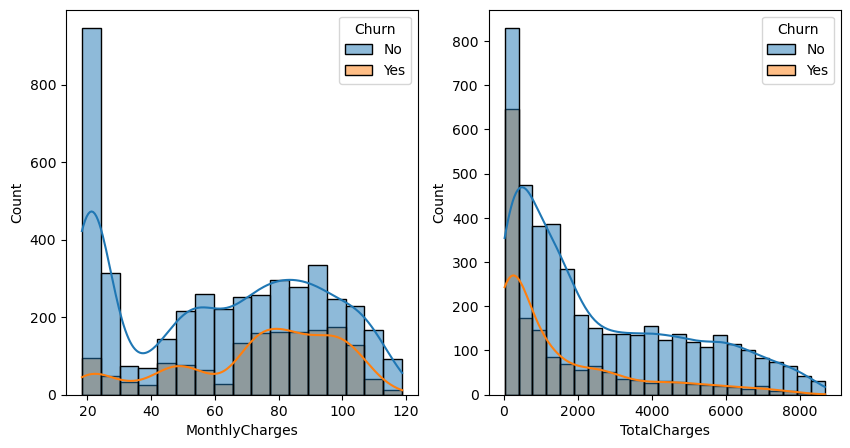

In [26]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))
sns.histplot(data = df_churn, x = "MonthlyCharges", hue = "Churn", kde = True, fill = True, ax = ax[0])
sns.histplot(data = df_churn, x = "TotalCharges", hue = "Churn", kde = True, fill = True, ax = ax[1]);